In [3]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# 시계열 예측 분석 모델
import pmdarima as pm
from pmdarima import model_selection

from prophet import Prophet
# 교차 검증 라이브러리
from prophet.diagnostics import cross_validation, performance_metrics

from utils.plotting import set_project_style

In [5]:
# 시각화 관련 기본 설정
set_project_style()

Seaborn style and Korean font (Malgun Gothic) applied.


In [6]:
# github 데이터셋
df_github = pd.read_csv('../dataset/github_all_years_cleaned.csv', encoding='utf-8')
df_github.head()

,id,name,full_name,owner,owner_type,description,language,stars,forks,watchers,...,topics,license,default_branch,has_wiki,has_pages,archived,period,search_text,ai_field,keyword
0,326059244,mirotalk,miroslavpejic85/mirotalk,miroslavpejic85,User,"🚀 WebRTC - P2P - Simple, Secure, Fast Real-Tim...",JavaScript,4015,680,4015,...,chatgpt|conference|conferencing|decentralized|...,GNU Affero General Public License v3.0,master,True,False,False,Before,"🚀 WebRTC - P2P - Simple, Secure, Fast Real-Tim...",LLM,NaN
1,326020989,TerrainAndAIPractice,tyler-lady/TerrainAndAIPractice,tyler-lady,User,A project I have used for general practice of ...,NaN,0,0,0,...,NaN,No License,main,True,False,False,Before,A project I have used for general practice of ...,Others,AI Agent
2,325951888,superpowers-skills,xitachixxx/superpowers-skills,xitachixxx,User,💪 Enhance your Claude Code superpowers with a ...,HTML,0,0,0,...,amazon-lex-chatbot|amazon-web-services|authent...,MIT License,main,True,False,False,Before,💪 Enhance your Claude Code superpowers with a ...,LLM,NaN
3,326066116,best-of-jupyter,ml-tooling/best-of-jupyter,ml-tooling,Organization,"🏆 A ranked list of awesome Jupyter Notebook, H...",NaN,1157,89,1157,...,awesome|best-of|best-of-list|collections|deep-...,Creative Commons Attribution Share Alike 4.0 I...,main,False,False,False,Before,"🏆 A ranked list of awesome Jupyter Notebook, H...",Others,NaN
4,326002236,ViT,FrancescoSaverioZuppichini/ViT,FrancescoSaverioZuppichini,User,Implementing Vi(sion)T(transformer),NaN,443,61,443,...,computer-vision|deep-learning,No License,main,True,False,False,Before,Implementing Vi(sion)T(transformer) computer-v...,NLP,NaN


In [ ]:
# 날짜로 변환
df_github['created_at'] = pd.to_datetime(df_github['created_at'])
print("원본 데이터 로딩 및 날짜 변환 완료")

원본 데이터 로딩 및 날짜 변환 완료


In [ ]:
# 주의 - 'ai_field' 컬럼에 있는 실제 값으로 수정해야 할 수 있음
# df_github['ai_field'].value_counts()로 실제 이름을 확인
target_fields = ['General ML','LLM', 'Deep Learning', 'Computer Vision', 'NLP']

df_ai_fields = df_github[df_github['ai_field'].isin(target_fields)]

print(f"4개 분야 필터링 완료 (총 {len(df_ai_fields)}개)")
print(df_ai_fields['ai_field'].value_counts())

4개 분야 필터링 완료 (총 925000개)
ai_field
General ML         375296
Deep Learning      265546
LLM                256161
NLP                 18728
Computer Vision      9269
Name: count, dtype: int64


In [37]:
# AI 분야별, 월별 개수 집계
monthly_ai_data = df_ai_fields.groupby([
    'ai_field',
    pd.Grouper(key='created_at', freq='ME') 
]).size().reset_index(name='count')

print("AI 분야별, 월별 집계 완료")
monthly_ai_data['ai_field'].value_counts()

AI 분야별, 월별 집계 완료


ai_field
Computer Vision    59
Deep Learning      59
General ML         59
LLM                59
NLP                59
Name: count, dtype: int64

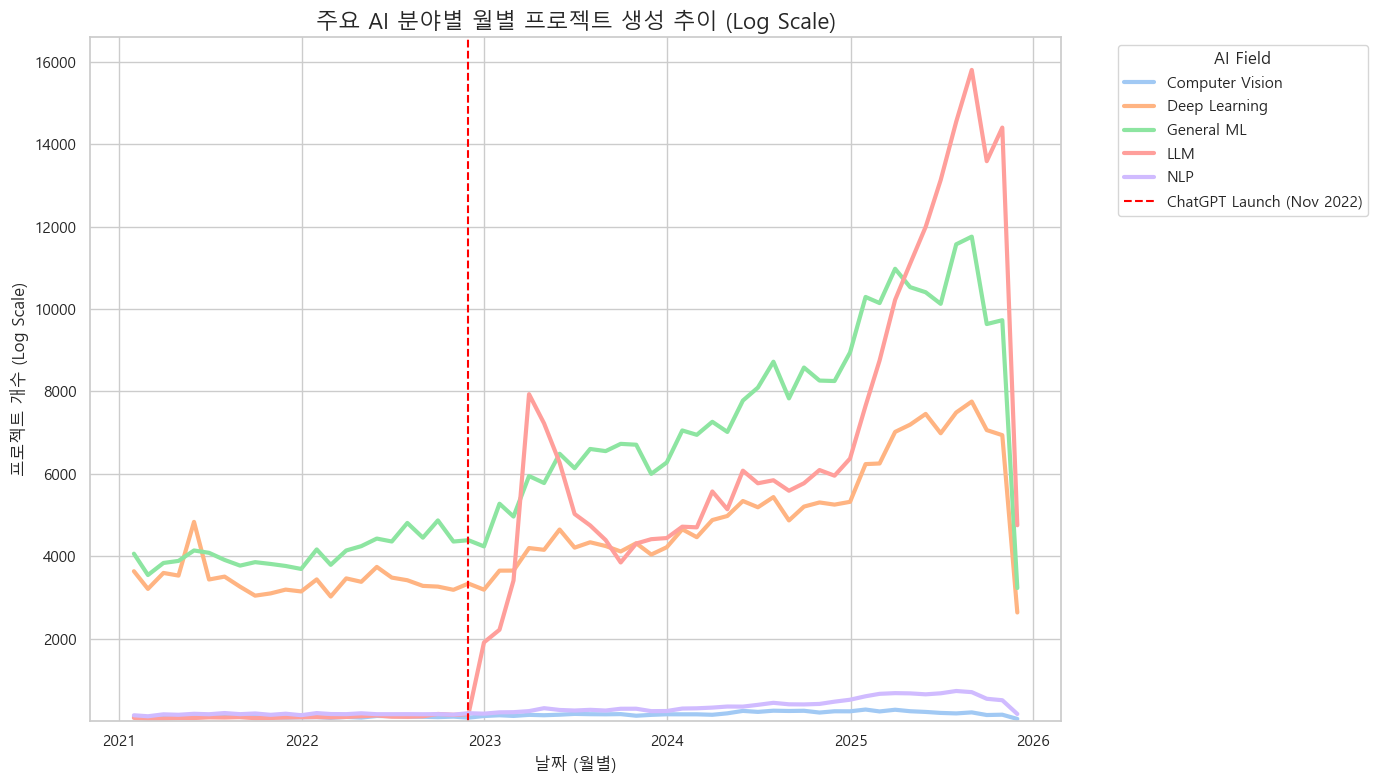

In [ ]:
plt.figure(figsize=(14, 8)) 

# 'ai_field'에 따라 4개의 라인 그리기
sns.lineplot(
    data=monthly_ai_data,
    x='created_at',
    y='count',
    hue='ai_field',  
    linewidth=3.0   
)

# ChatGPT 출시일 (2022년 11월 30일)에 수직선 표시
plt.axvline(pd.to_datetime('2022-11-30'), color='red', linestyle='--', label='ChatGPT Launch (Nov 2022)')

plt.title('주요 AI 분야별 월별 프로젝트 생성 추이 (Log Scale)', fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('프로젝트 개수 (Log Scale)', fontsize=12) # Y축이 Log Scale임
plt.legend(title='AI Field', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylim(bottom=1) # 0은 log 계산이 안되므로 1부터 시작
#plt.yscale('log')

plt.tight_layout()

plt.show()

In [42]:
# 시계열 분해 - 'LLM' 데이터만 필터링
llm_data = monthly_ai_data[monthly_ai_data['ai_field'] == 'LLM']
llm_trend_series = llm_data.set_index('created_at')['count']

print(f"'LLM' 데이터 준비 완료 (총 {len(llm_trend_series)} 개월)")

'LLM' 데이터 준비 완료 (총 59 개월)


In [49]:
# 'LLM' 시계열 분해 실행
if len(llm_trend_series) < 24:
    print(f"경고: 데이터가 {len(llm_trend_series)}개월(24개월 미만)이므로,")
    print("12개월 주기(period=12) 분석 결과가 부정확할 수 있습니다.")

# 0 값이 포함되어 있을 수 있으므로 'additive' 모델을 사용 (더 안정적)
model_type = 'additive'

decomposition_llm = seasonal_decompose(
    llm_trend_series, 
    model=model_type, 
    period=12
)

'LLM' 분야 월별 트렌드 시계열 분해 (X-Ray)


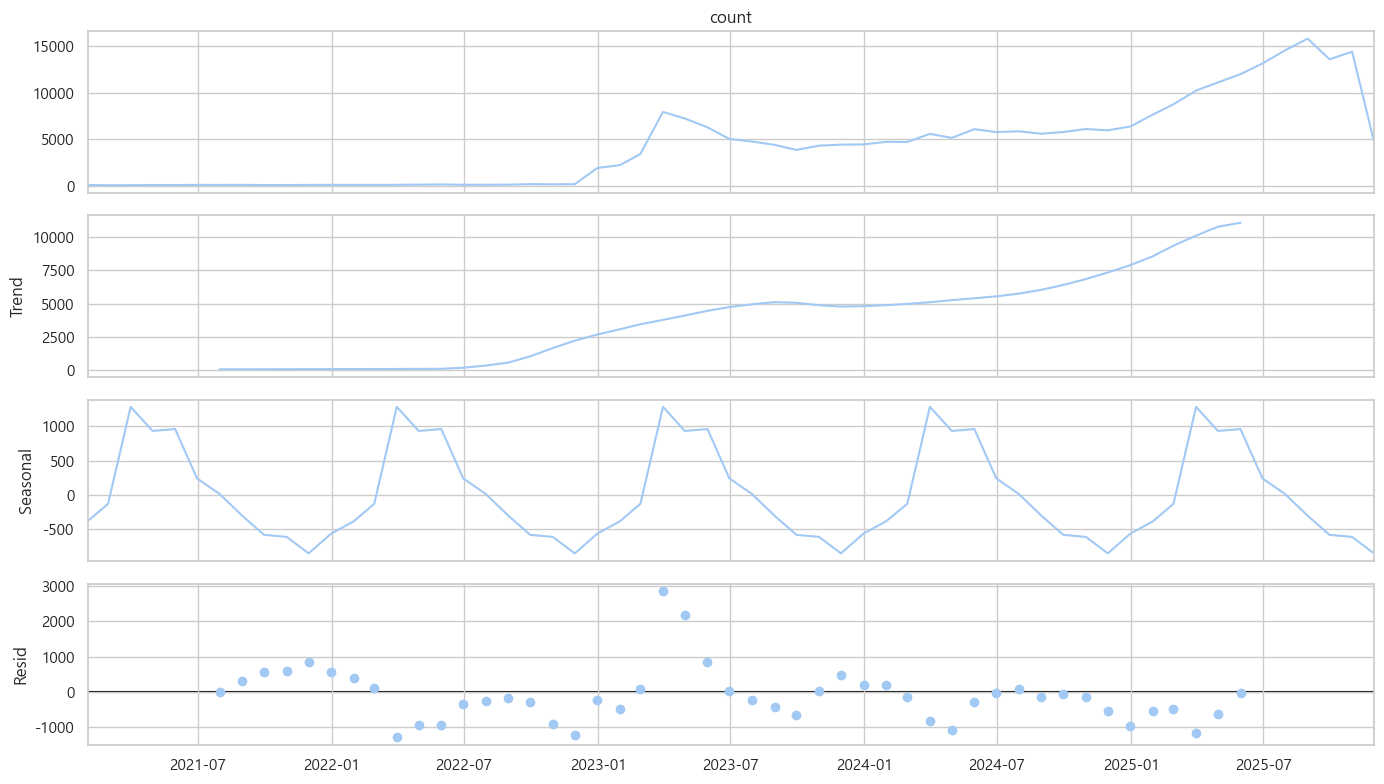

In [47]:
print("'LLM' 분야 월별 트렌드 시계열 분해 (X-Ray)")

# 4개의 그래프(Observed, Trend, Seasonal, Residual)를 그림
fig = decomposition_llm.plot()
fig.set_size_inches(14, 8)
plt.tight_layout()
plt.show()

In [51]:
# 'm=12' : 계절성 주기
# 'suppress_warnings=True' : 불필요한 경고 메시지 띄워줌
# 'stepwise=True' : 파라미터를 더 빨리 찾도록 도와줌

auto_model = pm.auto_arima(
    llm_trend_series, 
    start_p=1, start_q=1,
    max_p=3, max_q=3, 
    m=12,  # 12개월 주기
    start_P=0, 
    seasonal=True, # 계절성 모델 사용
    d=1, D=1, # d, D는 1로 설정하여 추세를 반영
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)

print("3. 모델 탐색 완료")
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=826.592, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=825.015, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=825.461, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=824.979, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=826.990, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=826.846, Time=0.48 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=826.839, Time=0.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=825.512, Time=0.36 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=828.868, Time=0.79 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=823.025, Time=0.18 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=824.965, Time=0.15 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=823.579, Time=0.17 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=826.963, Time=0.28 sec
 ARIMA(1,1,0)(0,1,1)[12]             

In [55]:
# n_periods=12 : 향후 12개월을 예측
n_periods_to_forecast = 12
future_forecast = auto_model.predict(n_periods=n_periods_to_forecast)

# 예측 결과를 보기 좋게 Pandas Series로 변환
# 예측 기간의 날짜 인덱스 생성
forecast_index = pd.date_range(
    start=llm_trend_series.index[-1] + pd.DateOffset(months=1), 
    periods=n_periods_to_forecast, 
    freq='ME' # 'ME' (월말) 기준으로 생성
)
forecast_series = pd.Series(future_forecast, index=forecast_index)

print("향후 12개월 예측 결과\n")
print(forecast_series)

향후 12개월 예측 결과

2025-12-31 00:00:00+00:00     5202.591264
2026-01-31 00:00:00+00:00     5946.859641
2026-02-28 00:00:00+00:00     6637.263451
2026-03-31 00:00:00+00:00     8163.475274
2026-04-30 00:00:00+00:00     8398.505350
2026-05-31 00:00:00+00:00     8952.038017
2026-06-30 00:00:00+00:00     9273.369009
2026-07-31 00:00:00+00:00     9952.654742
2026-08-31 00:00:00+00:00    10463.205363
2026-09-30 00:00:00+00:00     9350.564736
2026-10-31 00:00:00+00:00     9890.483511
2026-11-30 00:00:00+00:00     5117.171952
Freq: ME, dtype: float64


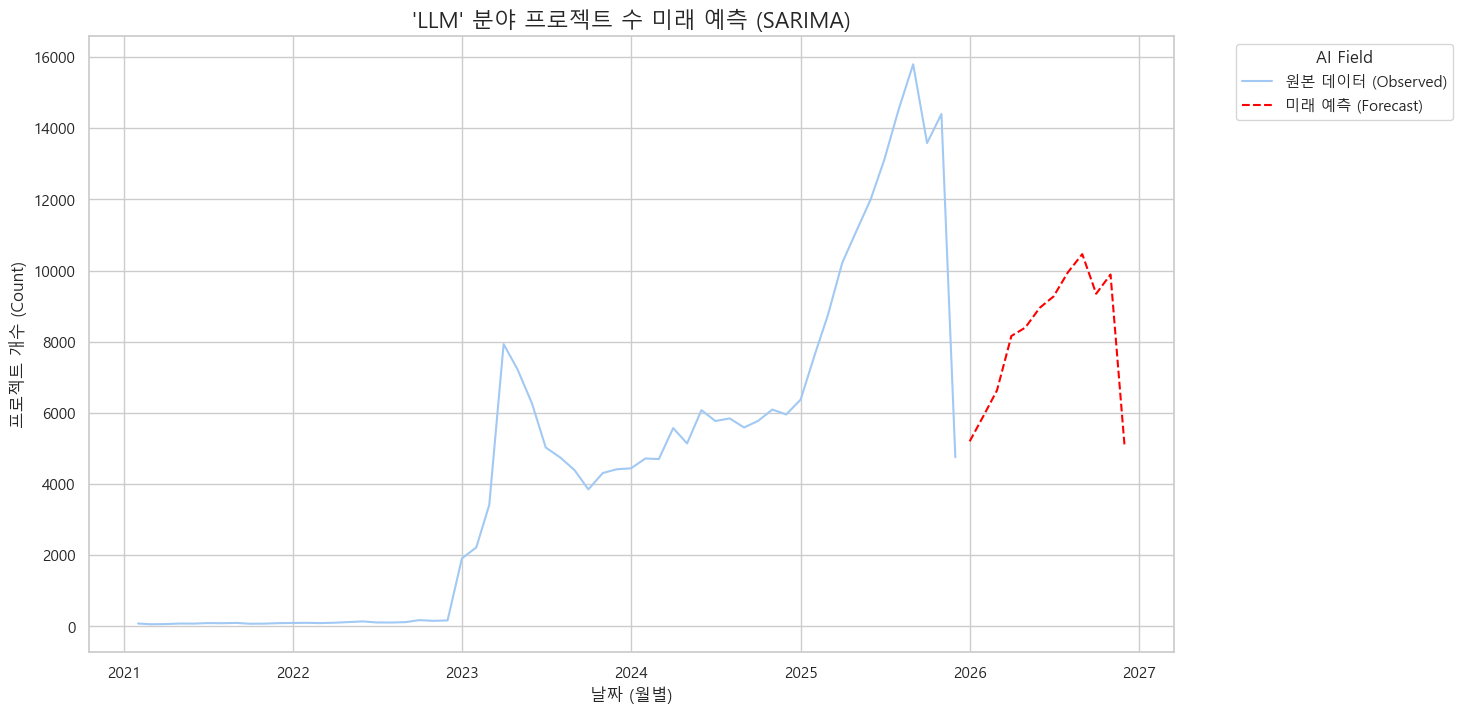

In [56]:
plt.figure(figsize=(14, 8))

# 원본 데이터 그리기
plt.plot(llm_trend_series, label='원본 데이터 (Observed)')

# 예측 데이터 그리기
plt.plot(forecast_series, color='red', linestyle='--', label='미래 예측 (Forecast)')

plt.title("'LLM' 분야 프로젝트 수 미래 예측 (SARIMA)", fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('프로젝트 개수 (Count)', fontsize=12)
plt.legend(title='AI Field', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [74]:
# Prophet은 'ds' (날짜)와 'y' (값) 컬럼명을 요구함.
df_prophet = llm_trend_series.reset_index()
df_prophet.columns = ['ds', 'y']

# Prophet은 타임존을 지원하지 않으므로, 'ds' 컬럼의 시간대 정보를 제거
df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)

print("Prophet 데이터 형식 변환 완료")

Prophet 데이터 형식 변환 완료


In [75]:
# 'holidays'라는 이름으로 이벤트 목록을 생성
events = pd.DataFrame({
    'holiday': 'ai_events',     # 이벤트 그룹 이름
    'ds': pd.to_datetime([
        '2022-11-30',           # ChatGPT 출시
        '2023-03-30',           # Auto-GPT 시대 (폭발적 증가 시작)
        '2025-07-31',           # (예시) 2025년 여름의 거대한 스파이크
    ]),
    'lower_window': 0,          # 이벤트 당일
    'upper_window': 2,          # 이벤트 당일 + 이후 2개월간 영향을 줌 (조절 가능)
})

print("'이벤트' 정의 완료")

'이벤트' 정의 완료


In [76]:
# Prophet 모델 학습
print("Prophet 모델 학습 시작...")

# 'holidays'에 우리가 정의한 이벤트 목록을 전달
# 'yearly_seasonality=True' : 12개월 계절성도 함께 고려
model_prophet = Prophet(holidays=events, yearly_seasonality=True)
model_prophet.fit(df_prophet)

print("모델 학습 완료")


19:00:57 - cmdstanpy - INFO - Chain [1] start processing


Prophet 모델 학습 시작...


19:00:57 - cmdstanpy - INFO - Chain [1] done processing


모델 학습 완료


In [77]:
# 미래 예측 (Forecast)
# 향후 12개월(365일)을 예측하는 미래 프레임을 생성
future = model_prophet.make_future_dataframe(periods=12, freq='ME')
forecast = model_prophet.predict(future)

print("미래 12개월 예측 완료")

미래 12개월 예측 완료


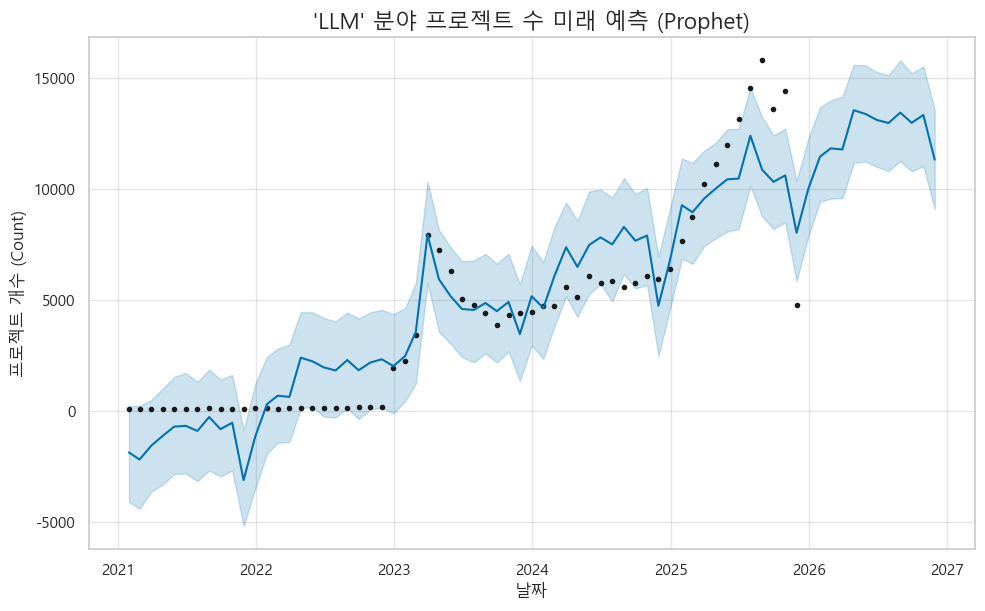


Prophet 시계열 분해 (X-Ray) 결과


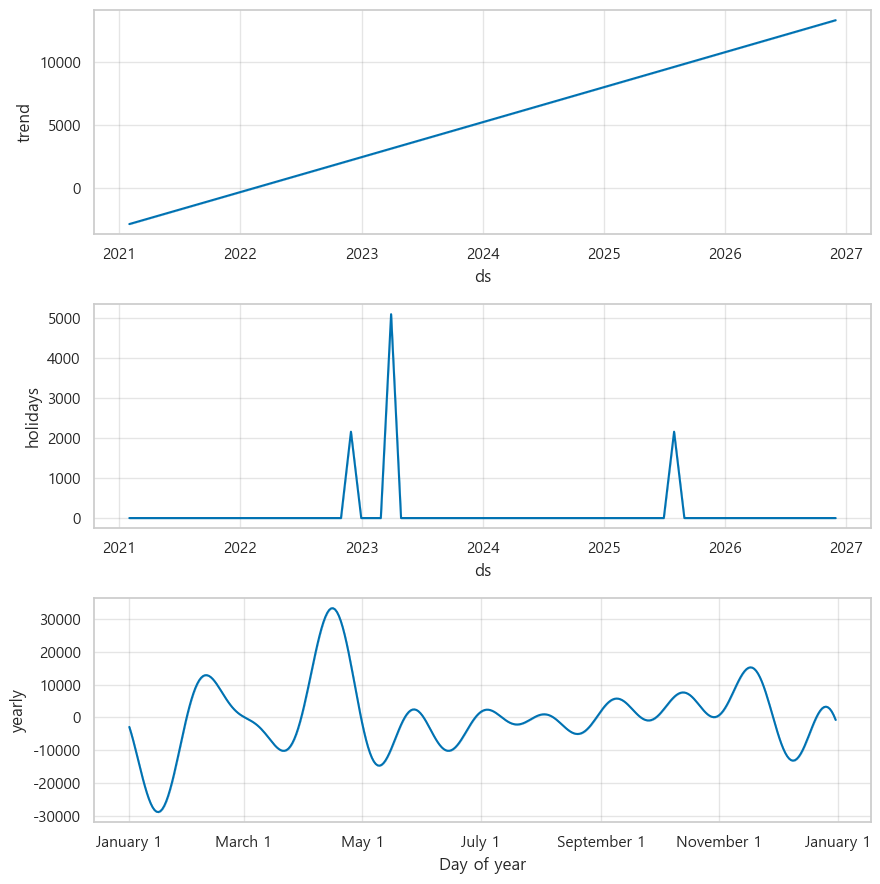

In [78]:
# Prophet의 내장 플롯 기능
fig1 = model_prophet.plot(forecast)
plt.title("'LLM' 분야 프로젝트 수 미래 예측 (Prophet)", fontsize=16)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('프로젝트 개수 (Count)', fontsize=12)
plt.show()

print("="*100)
# (가장 중요) 시계열 분해 결과 확인
print("\nProphet 시계열 분해 (X-Ray) 결과")

# Prophet이 '추세', '계절성', '이벤트'를 어떻게 분리했는지 확인
fig2 = model_prophet.plot_components(forecast)
plt.show()

In [79]:
# initial='730 days' : 최소 2년(730일)치 데이터로 첫 훈련
# period='180 days'  : 6개월(180일)마다 훈련 데이터를 늘려가며 테스트
# horizon='365 days' : 한 번 테스트할 때마다 1년(365일)치를 예측
df_cv = cross_validation(
    model_prophet, 
    initial='730 days', 
    period='180 days', 
    horizon='365 days'
)
print("="*50)
print("교차 검증 완료")
print("="*50)
print("교차 검증 결과 (일부)")
# 'yhat'은 예측값, 'y'는 실제값임
print(df_cv.head())

  0%|          | 0/4 [00:00<?, ?it/s]

19:01:07 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing
19:01:07 - cmdstanpy - INFO - Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1] done processing
19:01:08 - cmdstanpy - INFO - Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1] done processing
19:01:08 - cmdstanpy - INFO - Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1] done processing


교차 검증 완료
교차 검증 결과 (일부)
          ds         yhat  yhat_lower   yhat_upper     y     cutoff
0 2023-06-30   984.044878 -136.503677  2048.384504  5028 2023-06-09
1 2023-07-31  1450.711817  447.015066  2621.325375  4751 2023-06-09
2 2023-08-31  1711.864154  737.663938  2707.182330  4395 2023-06-09
3 2023-09-30  1694.423784  640.079736  2788.378842  3852 2023-06-09
4 2023-10-31  1152.891827   85.478922  2269.706815  4311 2023-06-09


In [80]:

# 성능 지표(오차 점수) 계산
# 교차 검증 결과(df_cv)를 바탕으로 오차 점수(MAE, RMSE 등)를 계산
df_performance = performance_metrics(df_cv)

print("모델 성능 평가 점수 (MAE, RMSE 등)")
print(df_performance.head()) # 'horizon'(예측 시점)별 오차를 보여줌

모델 성능 평가 점수 (MAE, RMSE 등)
  horizon           mse         rmse          mae      mape     mdape  \
0 31 days  4.990107e+06  2233.854841  1753.962576  0.345621  0.254657   
1 52 days  3.624690e+06  1903.861790  1568.045842  0.318213  0.254657   
2 56 days  3.199479e+06  1788.708676  1389.382267  0.275270  0.168772   
3 58 days  3.182059e+06  1783.832600  1364.321049  0.270768  0.168772   
4 62 days  2.931772e+06  1712.241941  1165.372973  0.238034  0.113643   

      smape  coverage  
0  0.470921      0.50  
1  0.400679      0.50  
2  0.374909      0.75  
3  0.370665      0.75  
4  0.334517      0.75  


In [81]:
# 전체 평균 오차(MAE) 확인
# MAE (Mean Absolute Error, 평균 절대 오차)
# "이 모델은 평균적으로 실제 값과 ±[MAE 값]만큼 차이 나게 예측한다"
mean_mae = df_performance['mae'].mean()

print("최종 결론: 이 모델의 평균 절대 오차(MAE)")
print(f"이 모델은 평균적으로 ± {mean_mae:,.2f} 개의 프로젝트 수를 차이 나게 예측합니다.")

최종 결론: 이 모델의 평균 절대 오차(MAE)
이 모델은 평균적으로 ± 2,217.07 개의 프로젝트 수를 차이 나게 예측합니다.
